In [1]:
%matplotlib inline
%load_ext dotenv
%dotenv env.sh
import pandas as pd
import numpy as np
import plotnine as pn
import os
import os.path as osp
from cytokit import config as ck_config
from cytokit.function import data as ck_data
exp_variant = 'v01'

In [15]:
df = pd.read_csv('experiments.csv')
df['has_peptide'] = df['cond'].str.match(r'.*\-wp(\-|$)').map({True: 'w/ Peptide', False: 'No Peptide'})
df['cell_count'] = df['name'].str.extract(r'([\d.]+kT)', expand=False)
df['sta_conc'] = df['name'].str.extract(r'([\d.]+uM)', expand=False)
df['label'] = df.apply(lambda r: '{}-{}-r{:01d}'.format(r['cell_count'], r['sta_conc'], r['rep']), axis=1)
df['key'] = df.apply(lambda r: '{}-{}-{}'.format(r['has_peptide'], r['sta_conc'], r['cell_count']), axis=1)
df['rep'] = df['rep'].apply(lambda v: 'r{}'.format(v))
df['output_dir'] = df.apply(lambda r: osp.join(os.environ['EXP_GROUP_OUT_DIR'], r['name'], exp_variant), axis=1)

# Filter to experiments with data and load config
df = df[df.apply(lambda r: osp.exists(osp.join(r['output_dir'], 'cytometry', 'data.csv')), axis=1)]
df['config'] = df.apply(lambda r: ck_config.load(osp.join(r['output_dir'], 'config')), axis=1)
df.head()

,name,conf,dir,grid,n_ch,n_tiles,n_z,cond,rep,z_pitch,has_peptide,cell_count,sta_conc,label,key,output_dir,config
0,0000kT-0uM-np-XY01-1,experiment.yaml,untreated,XY01,3,33,8,0000kT-0uM-np,r1,200,No Peptide,0000kT,0uM,0000kT-0uM-r1,No Peptide-0uM-0000kT,/lab/data/spheroid/20190830-co-culture/output/...,"{'acquisition': {'tile_overlap_y': 432, 'objec..."
1,0000kT-0uM-np-XY02-2,experiment.yaml,untreated,XY02,3,33,7,0000kT-0uM-np,r2,200,No Peptide,0000kT,0uM,0000kT-0uM-r2,No Peptide-0uM-0000kT,/lab/data/spheroid/20190830-co-culture/output/...,"{'acquisition': {'tile_overlap_y': 432, 'objec..."
2,0000kT-0uM-np-XY03-3,experiment.yaml,untreated,XY03,3,33,8,0000kT-0uM-np,r3,200,No Peptide,0000kT,0uM,0000kT-0uM-r3,No Peptide-0uM-0000kT,/lab/data/spheroid/20190830-co-culture/output/...,"{'acquisition': {'tile_overlap_y': 432, 'objec..."
3,0000kT-4uM-np-XY01-1,experiment.yaml,4uMsta,XY01,3,33,6,0000kT-4uM-np,r1,200,No Peptide,0000kT,4uM,0000kT-4uM-r1,No Peptide-4uM-0000kT,/lab/data/spheroid/20190830-co-culture/output/...,"{'acquisition': {'tile_overlap_y': 432, 'objec..."
4,0000kT-4uM-np-XY02-2,experiment.yaml,4uMsta,XY02,3,33,11,0000kT-4uM-np,r2,200,No Peptide,0000kT,4uM,0000kT-4uM-r2,No Peptide-4uM-0000kT,/lab/data/spheroid/20190830-co-culture/output/...,"{'acquisition': {'tile_overlap_y': 432, 'objec..."


### Cell Data 

In [16]:
dfa = pd.concat([
    ck_data.get_cytometry_data(r['output_dir'], r['config']).assign(**r[[
        'name', 'grid', 'cond', 'has_peptide', 'cell_count', 'sta_conc', 'label', 'rep', 'key'
    ]].add_prefix('exp:').to_dict())
    for i, r in df.iterrows()
])
dfa = dfa.rename(columns=lambda c: c.replace(':', '_'))
dfa.head()

,region_index,tile_index,tile_x,tile_y,rid,rx,ry,id,x,y,...,ni_SPHEROID_mean,exp_cell_count,exp_cond,exp_grid,exp_has_peptide,exp_key,exp_label,exp_name,exp_rep,exp_sta_conc
0,0,0,0,0,0,678.0,1000.423888,1,678.0,1000.423888,...,0.0,0000kT,0000kT-0uM-np,XY01,No Peptide,No Peptide-0uM-0000kT,0000kT-0uM-r1,0000kT-0uM-np-XY01-1,r1,0uM
1,0,0,0,0,1,1118.0,981.000000,2,1118.0,981.000000,...,0.0,0000kT,0000kT-0uM-np,XY01,No Peptide,No Peptide-0uM-0000kT,0000kT-0uM-r1,0000kT-0uM-np-XY01-1,r1,0uM
2,0,0,0,0,2,693.0,975.000000,3,693.0,975.000000,...,0.0,0000kT,0000kT-0uM-np,XY01,No Peptide,No Peptide-0uM-0000kT,0000kT-0uM-r1,0000kT-0uM-np-XY01-1,r1,0uM
3,0,0,0,0,3,1256.0,963.000000,4,1256.0,963.000000,...,0.0,0000kT,0000kT-0uM-np,XY01,No Peptide,No Peptide-0uM-0000kT,0000kT-0uM-r1,0000kT-0uM-np-XY01-1,r1,0uM
4,0,0,0,0,4,711.0,868.000000,5,711.0,868.000000,...,0.0,0000kT,0000kT-0uM-np,XY01,No Peptide,No Peptide-0uM-0000kT,0000kT-0uM-r1,0000kT-0uM-np-XY01-1,r1,0uM


In [17]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 662510 entries, 0 to 875
Data columns (total 44 columns):
region_index        662510 non-null int64
tile_index          662510 non-null int64
tile_x              662510 non-null int64
tile_y              662510 non-null int64
rid                 662510 non-null int64
rx                  662510 non-null float64
ry                  662510 non-null float64
id                  662510 non-null int64
x                   662510 non-null float64
y                   662510 non-null float64
z                   662510 non-null int64
cm_circularity      662510 non-null float64
cm_diameter         662510 non-null float64
cm_diameter_vx      662510 non-null float64
cm_perimeter        662510 non-null float64
cm_size             662510 non-null float64
cm_size_vx          662510 non-null int64
cm_solidity         662510 non-null float64
nm_circularity      662510 non-null float64
nm_diameter         662510 non-null float64
nm_diameter_vx      662510 n

In [18]:
dfa['cb_on_border'].value_counts()

0    586193
1     76317
Name: cb_on_border, dtype: int64

In [19]:
def select_z_plane(g):
    z = g['z'].value_counts().idxmax()
    return g[g['z'] == z]

dfs = (
    dfa
    # Restrict to cells in a spheroid
    .pipe(lambda df: df[df['ci_SPHEROID_mean'] > 0])
    # Select z plane with most cells
    .groupby(['exp_name', 'tile_index'], group_keys=False).apply(select_z_plane)
)
assert (dfs.groupby(['exp_name', 'tile_index'])['z'].nunique() == 1).all()
dfs.groupby(['exp_name', 'tile_index'])['z'].max().unstack().fillna(0).astype(int)

tile_index,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
exp_name,,,,,,,,,,,,,,,,,,,,,
0000kT-0uM-np-XY01-1,4,4,4,4,5,4,5,5,5,3,...,5,5,4,5,5,5,5,5,5,5
0000kT-0uM-np-XY02-2,4,4,0,0,5,5,5,5,0,0,...,5,5,5,6,4,5,5,5,5,4
0000kT-0uM-np-XY03-3,0,5,0,4,5,5,5,5,4,7,...,5,5,4,6,2,4,5,4,5,2
0000kT-4uM-np-XY01-1,3,3,3,4,3,4,3,3,4,4,...,4,4,3,3,3,3,3,3,3,3
0000kT-4uM-np-XY02-2,8,8,7,8,0,8,7,8,8,8,...,8,8,8,8,8,8,7,0,8,7
0000kT-4uM-np-XY03-3,5,5,5,5,5,5,6,5,5,5,...,5,0,5,5,5,5,5,5,5,5
0500kT-0uM-np-XY01-1,4,4,4,4,4,5,4,4,4,4,...,3,4,0,3,3,3,4,3,4,3
0500kT-0uM-np-XY02-2,0,4,3,3,4,4,5,3,0,0,...,5,5,4,5,5,3,4,5,4,4
0500kT-0uM-np-XY03-3,4,4,4,4,4,4,4,4,4,5,...,4,3,4,4,0,4,4,4,4,4


In [20]:
dfsct = dfs.groupby(['exp_name', 'exp_key', 'exp_has_peptide', 'exp_rep', 'exp_sta_conc']).size().rename('value').reset_index()
dfsct

,exp_name,exp_key,exp_has_peptide,exp_rep,exp_sta_conc,value
0,0000kT-0uM-np-XY01-1,No Peptide-0uM-0000kT,No Peptide,r1,0uM,2161
1,0000kT-0uM-np-XY02-2,No Peptide-0uM-0000kT,No Peptide,r2,0uM,1855
2,0000kT-0uM-np-XY03-3,No Peptide-0uM-0000kT,No Peptide,r3,0uM,2727
3,0000kT-4uM-np-XY01-1,No Peptide-4uM-0000kT,No Peptide,r1,4uM,2250
4,0000kT-4uM-np-XY02-2,No Peptide-4uM-0000kT,No Peptide,r2,4uM,1742
5,0000kT-4uM-np-XY03-3,No Peptide-4uM-0000kT,No Peptide,r3,4uM,2287
6,0500kT-0uM-np-XY01-1,No Peptide-0uM-0500kT,No Peptide,r1,0uM,2411
7,0500kT-0uM-np-XY02-2,No Peptide-0uM-0500kT,No Peptide,r2,0uM,1496
8,0500kT-0uM-np-XY03-3,No Peptide-0uM-0500kT,No Peptide,r3,0uM,2610
9,0500kT-0uM-wp-XY01-1,w/ Peptide-0uM-0500kT,w/ Peptide,r1,0uM,1534


In [21]:
def plot_series(df, width=.1):
    dfg = df.groupby(['exp_key', 'exp_has_peptide', 'exp_sta_conc'])['value'].mean().rename('value').reset_index()
    return (
        pn.ggplot(df, pn.aes(x='exp_key', y='value')) + 
        pn.geom_jitter(
            width=width, height=0, random_state=0, 
            mapping=pn.aes(fill='exp_rep', color='exp_rep', shape='exp_has_peptide', size='exp_sta_conc')
        ) + 
        pn.geom_point(data=dfg, mapping=pn.aes(x='exp_key', y='value', shape='exp_has_peptide', size='exp_sta_conc'), color='black', fill='black') +
        pn.geom_line(data=dfg, mapping=pn.aes(x='exp_key', y='value', group=1)) +
        pn.theme_bw() + 
        pn.labs(x='Condition', color='Replicate', fill='Replicate', shape='Peptide', size='STA') + 
        pn.scale_size_discrete(range=(3, 5)) + 
        pn.theme(figure_size=(12, 4), axis_text_x=pn.element_text(rotation=45, hjust=1))
    )

In [22]:
dfsct[dfsct['exp_key'] == 'No Peptide-0uM-2000kT']

,exp_name,exp_key,exp_has_peptide,exp_rep,exp_sta_conc,value
18,2000kT-0uM-np-XY01-1,No Peptide-0uM-2000kT,No Peptide,r1,0uM,1658
19,2000kT-0uM-np-XY02-2,No Peptide-0uM-2000kT,No Peptide,r2,0uM,2825
20,2000kT-0uM-np-XY03-3,No Peptide-0uM-2000kT,No Peptide,r3,0uM,2092


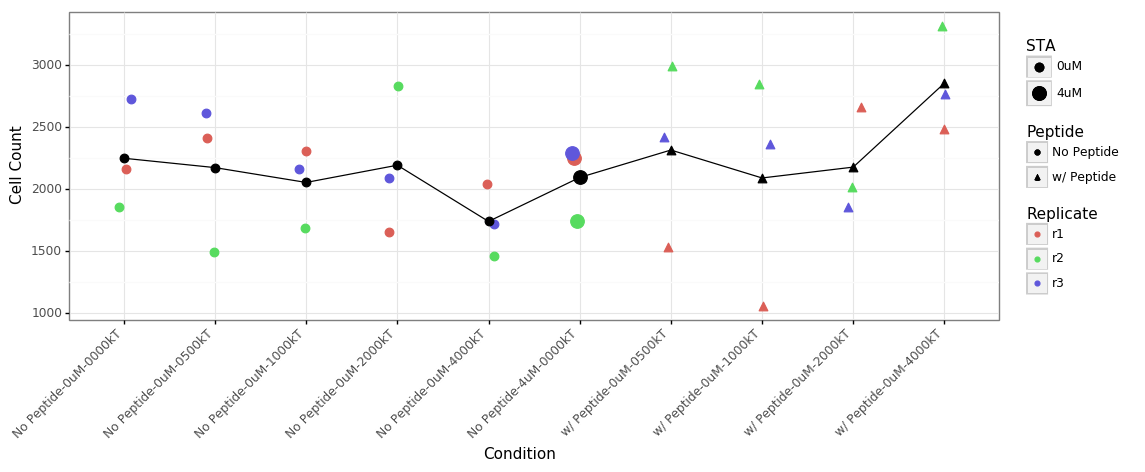

<ggplot: (8763330522572)>

In [23]:
plot_series(dfsct) + pn.labs(y='Cell Count')

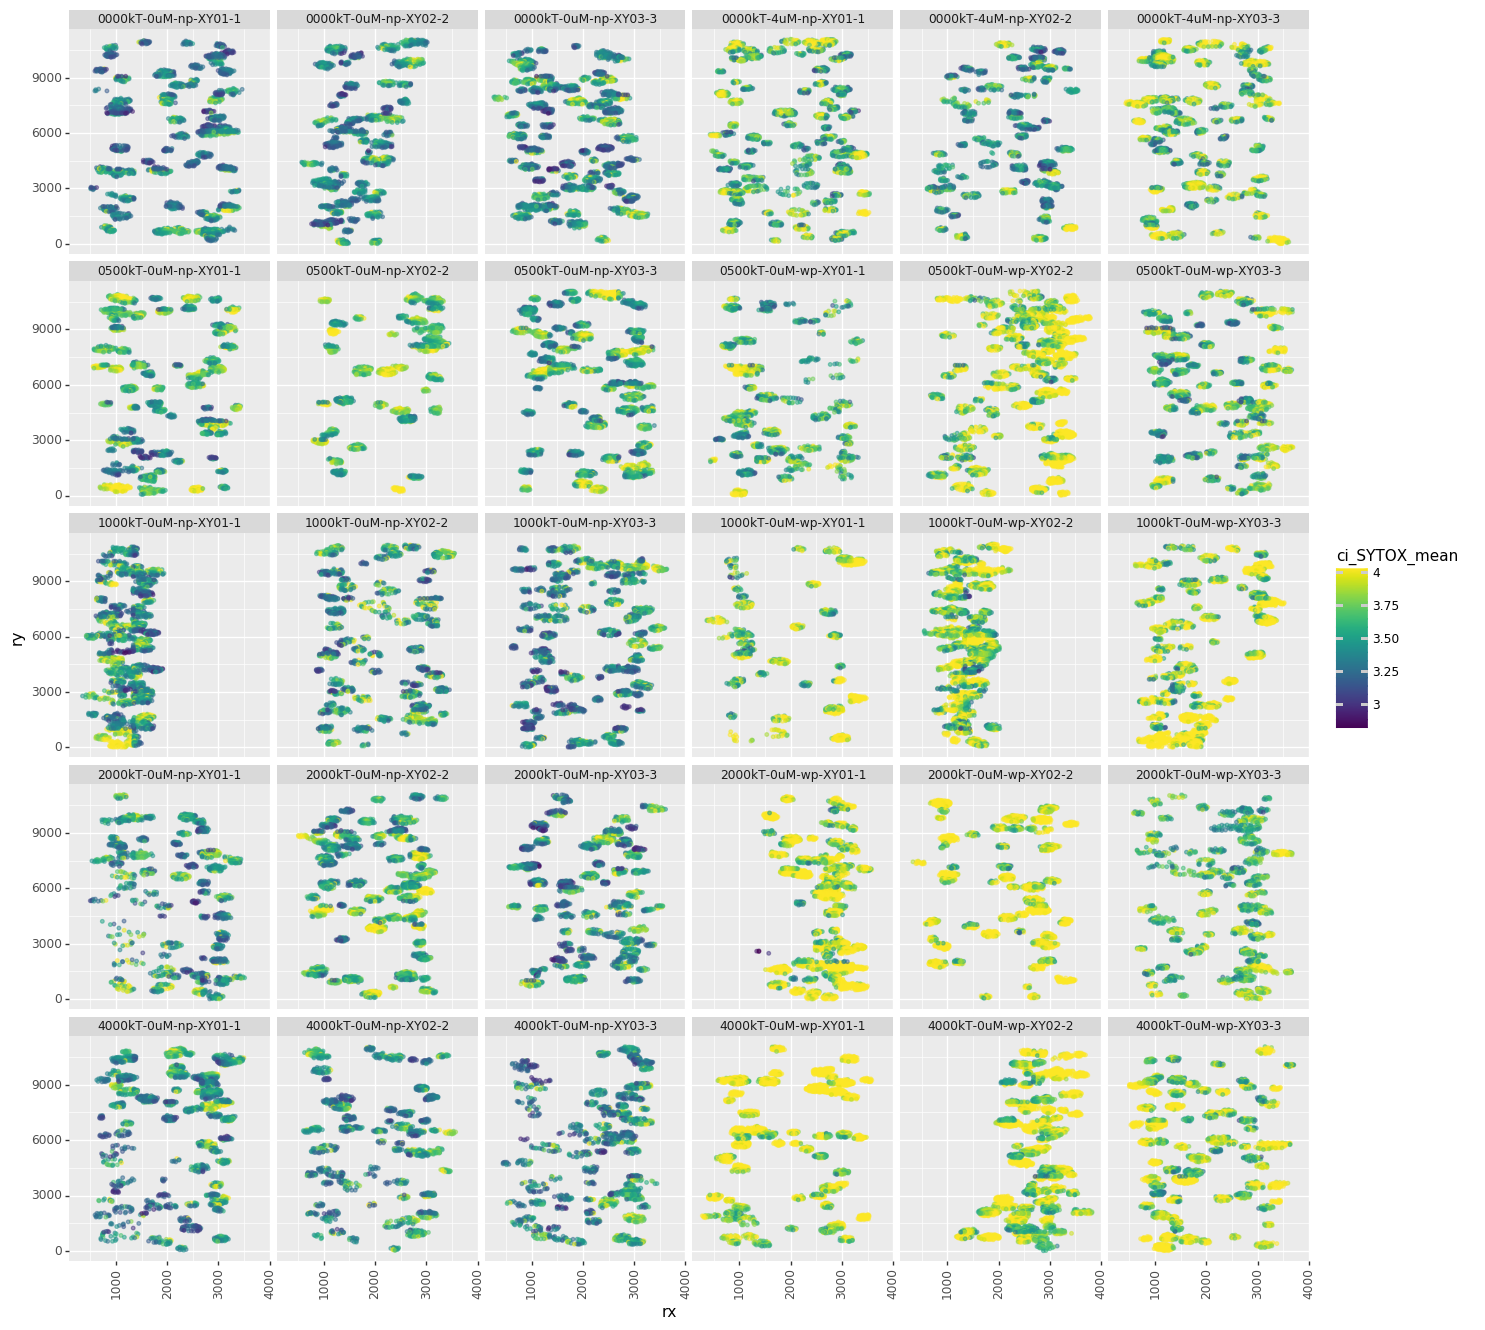

<ggplot: (8763330530473)>

In [24]:
(
    pn.ggplot(
        dfs.assign(ci_SYTOX_mean=lambda df: df['ci_SYTOX_mean'].apply(np.log10).clip(0, 4)), 
        pn.aes(x='rx', y='ry', fill='ci_SYTOX_mean', color='ci_SYTOX_mean')
    ) + 
    pn.geom_point(size=1, alpha=.5) + 
    pn.facet_wrap('~exp_name') + 
    pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(16, 16))
)

In [25]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65783 entries, 161 to 782
Data columns (total 44 columns):
region_index        65783 non-null int64
tile_index          65783 non-null int64
tile_x              65783 non-null int64
tile_y              65783 non-null int64
rid                 65783 non-null int64
rx                  65783 non-null float64
ry                  65783 non-null float64
id                  65783 non-null int64
x                   65783 non-null float64
y                   65783 non-null float64
z                   65783 non-null int64
cm_circularity      65783 non-null float64
cm_diameter         65783 non-null float64
cm_diameter_vx      65783 non-null float64
cm_perimeter        65783 non-null float64
cm_size             65783 non-null float64
cm_size_vx          65783 non-null int64
cm_solidity         65783 non-null float64
nm_circularity      65783 non-null float64
nm_diameter         65783 non-null float64
nm_diameter_vx      65783 non-null float64
nm_p

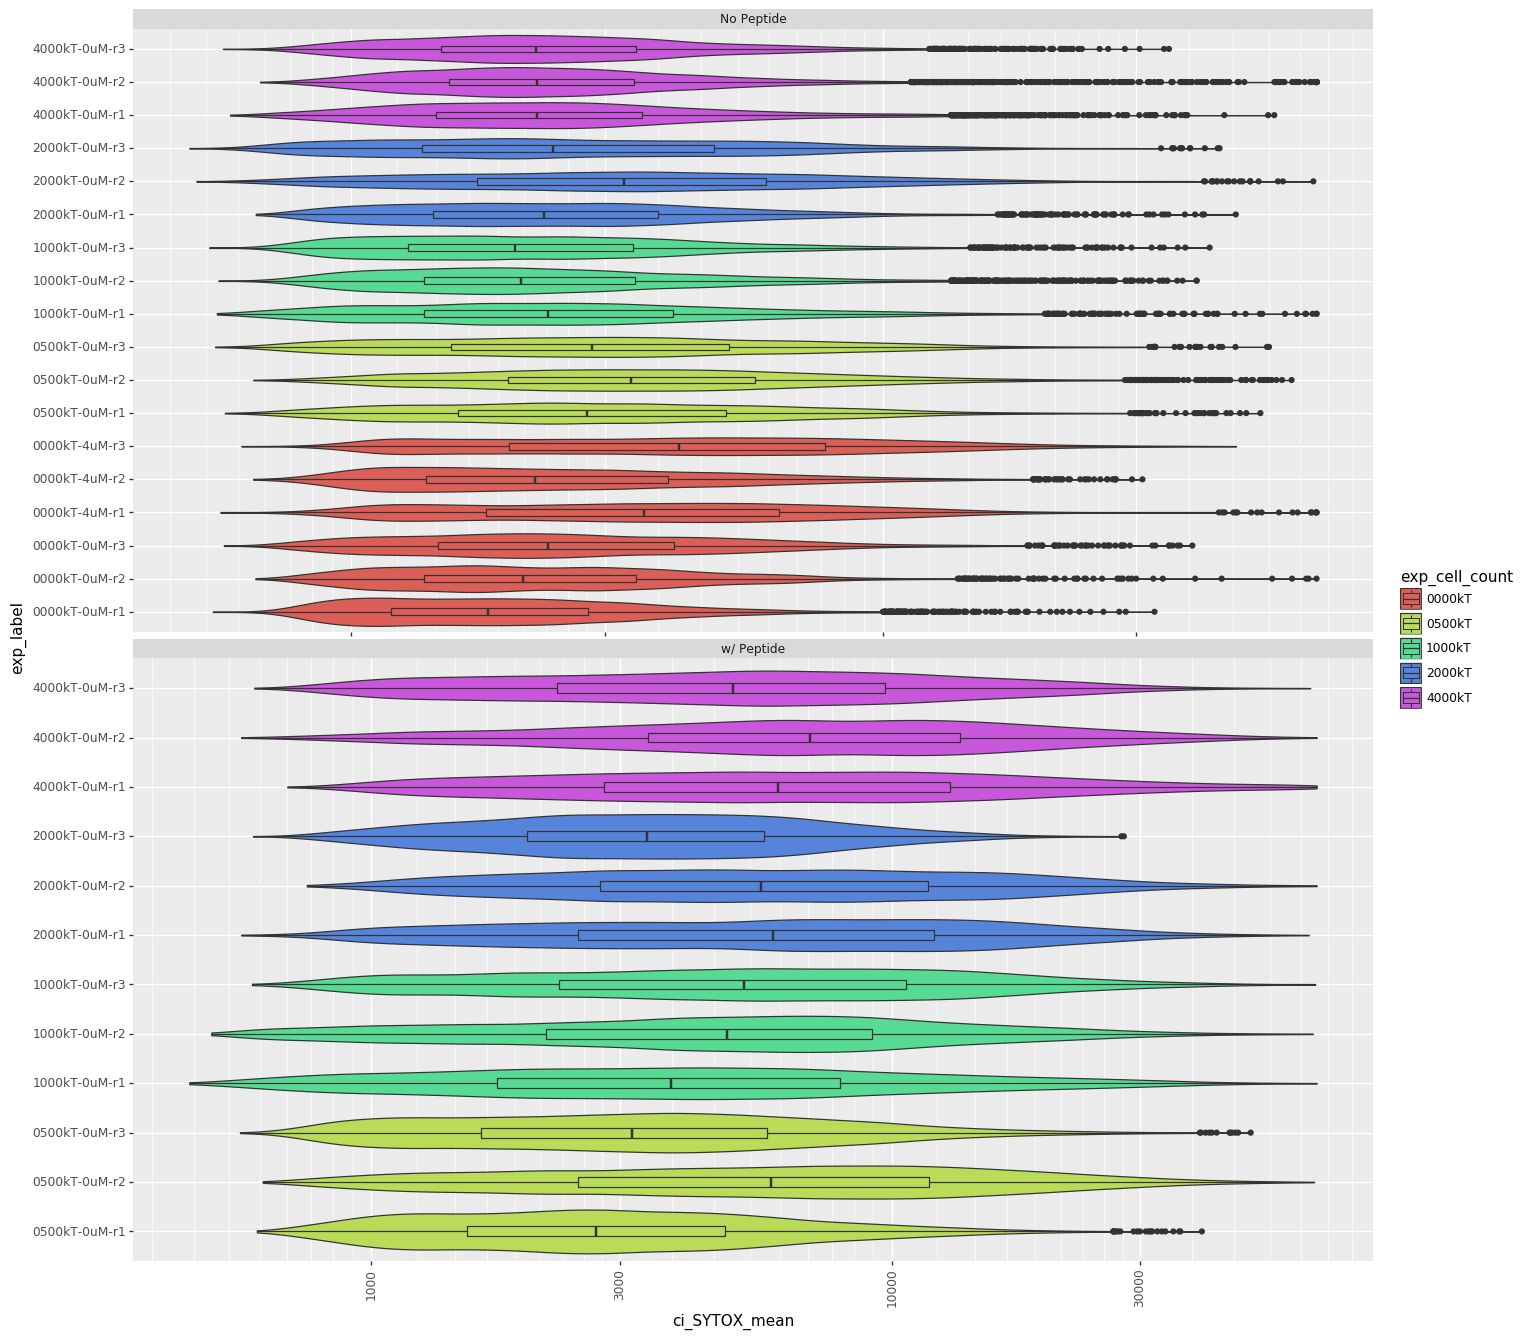

<ggplot: (8763332979425)>

In [26]:
(
    pn.ggplot(
        dfa,
        pn.aes(x='exp_label', y='ci_SYTOX_mean', fill='exp_cell_count')
    ) + 
    pn.geom_violin() + 
    pn.geom_boxplot(width=.2) + 
    pn.coord_flip() + 
    pn.scale_y_log10() +
    pn.facet_wrap('~ exp_has_peptide', ncol=1, nrow=2, scales='free') + 
    pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(16, 16))
)

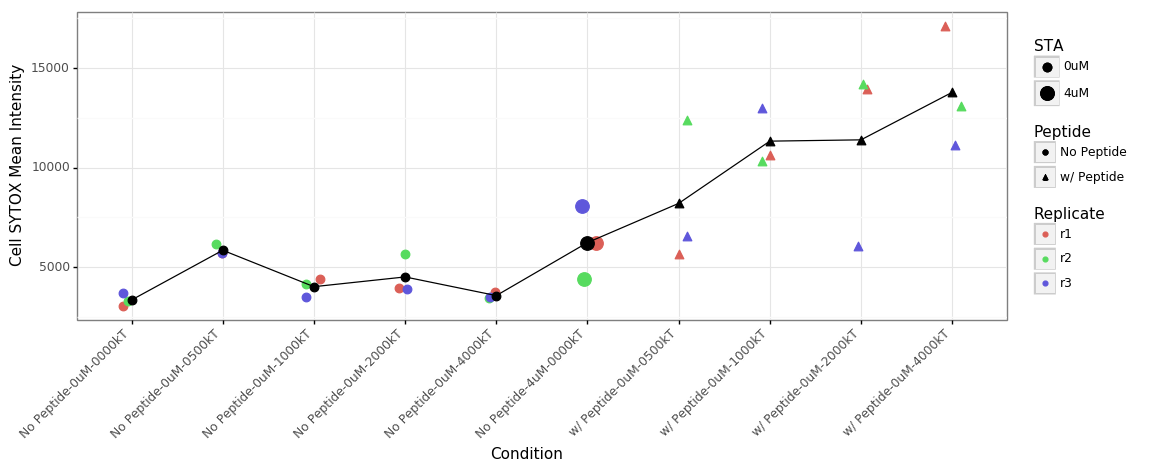

<ggplot: (-9223363273524376846)>

In [27]:
dfsval = dfs.groupby(['exp_name', 'exp_key', 'exp_has_peptide', 'exp_rep', 'exp_sta_conc'])['ci_SYTOX_mean'].mean().rename('value').reset_index()
plot_series(dfsval) + pn.labs(y='Cell SYTOX Mean Intensity')

### Spheroid Data

In [28]:
dfsh = pd.concat([
    pd.read_csv(osp.join(r['output_dir'], 'cytometry', 'data.spheroid.csv')).assign(**r[[
        'name', 'grid', 'cond', 'has_peptide', 'cell_count', 'sta_conc', 'label', 'rep', 'key'
    ]].add_prefix('exp:').to_dict())
    for i, r in df.iterrows()
])
dfsh = dfsh.rename(columns=lambda c: c.replace(':', '_'))
dfsh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1983 entries, 0 to 72
Data columns (total 28 columns):
id                 1983 non-null int64
x                  1983 non-null float64
y                  1983 non-null float64
z                  1983 non-null int64
cm_circularity     1983 non-null float64
cm_diameter        1983 non-null float64
cm_perimeter       1983 non-null float64
cm_size            1983 non-null int64
cm_solidity        1983 non-null float64
nm_circularity     1983 non-null float64
nm_diameter        1983 non-null float64
nm_perimeter       1983 non-null float64
nm_size            1983 non-null int64
nm_solidity        1983 non-null float64
cb_on_border       1983 non-null int64
nb_on_border       1983 non-null int64
ci_SYTOX_mean      1983 non-null float64
ci_HOECHST_mean    1983 non-null float64
ci_BF_mean         1983 non-null float64
exp_cell_count     1983 non-null object
exp_cond           1983 non-null object
exp_grid           1983 non-null object
exp_has_

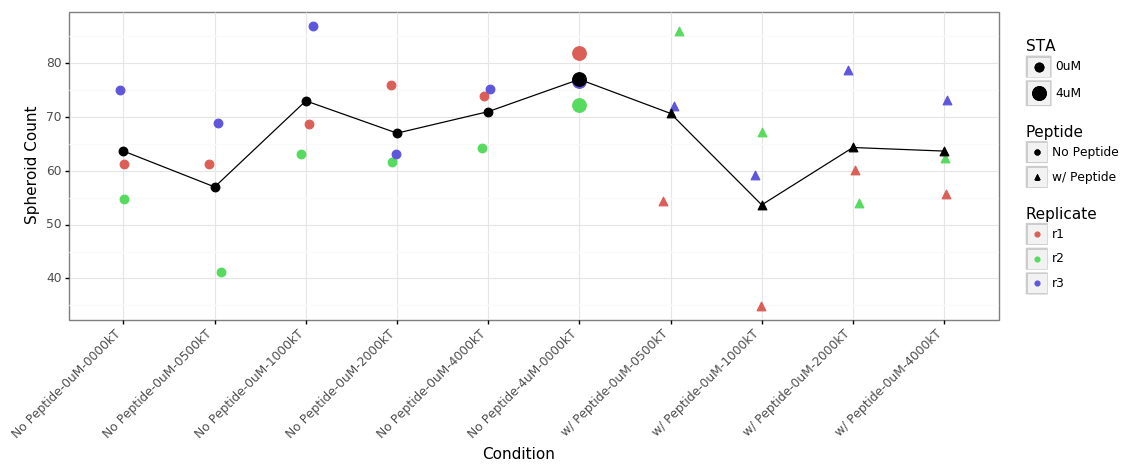

<ggplot: (-9223363273521803716)>

In [29]:
dfshct = dfsh.groupby(['exp_name', 'exp_key', 'exp_has_peptide', 'exp_rep', 'exp_sta_conc']).size().rename('value').reset_index()
plot_series(dfshct) + pn.labs(y='Spheroid Count')

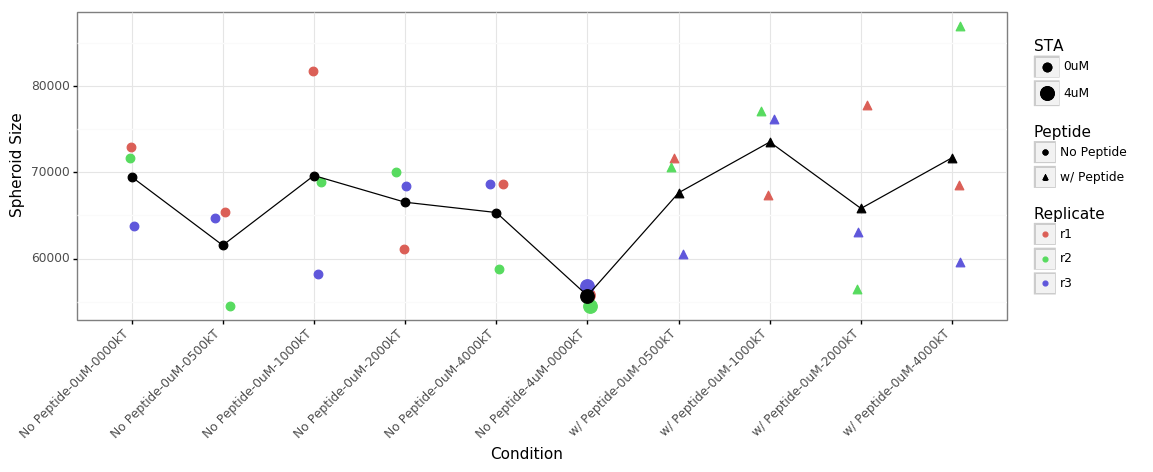

<ggplot: (8763310760228)>

In [30]:
dfshsz = dfsh.groupby(['exp_name', 'exp_key', 'exp_has_peptide', 'exp_rep', 'exp_sta_conc'])['cm_size'].mean().rename('value').reset_index()
plot_series(dfshsz) + pn.labs(y='Spheroid Size')

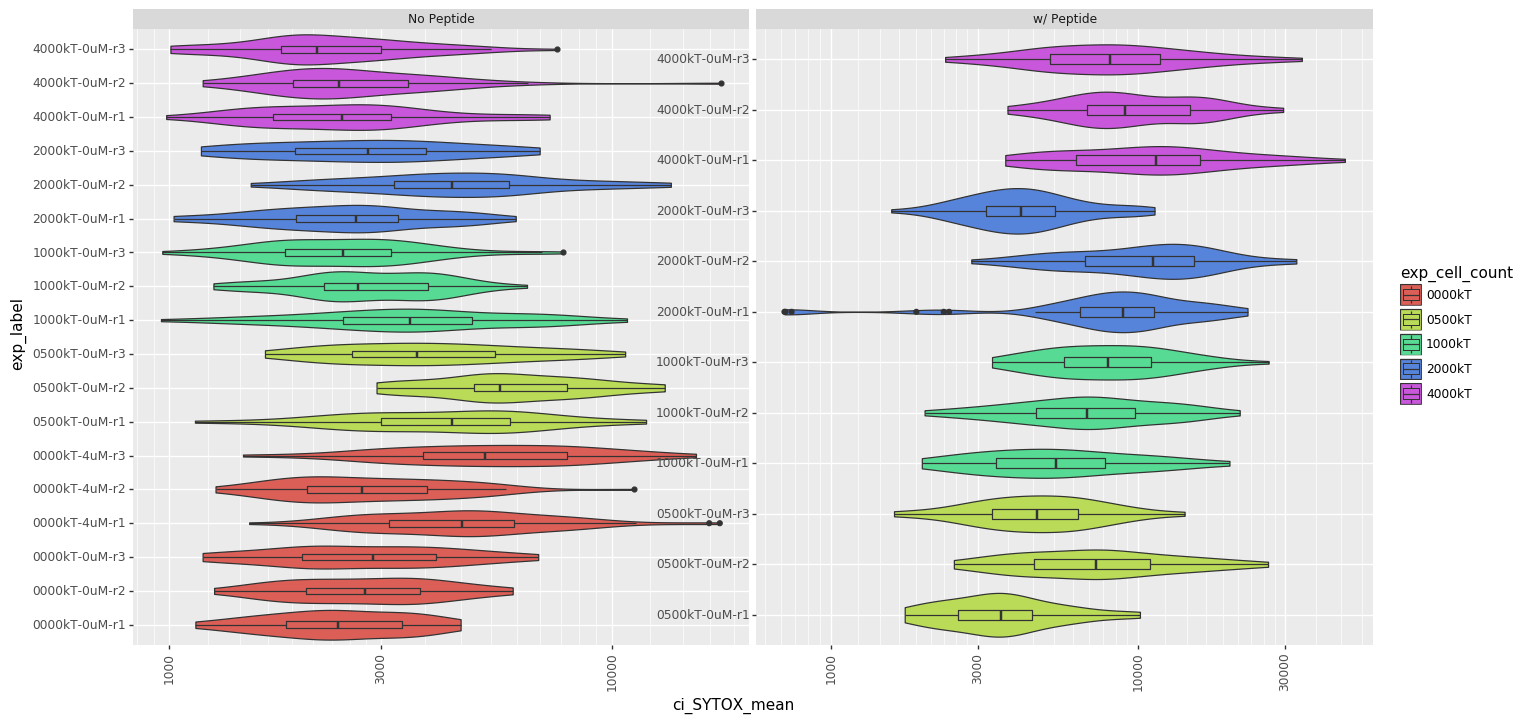

<ggplot: (-9223363273527116435)>

In [31]:
(
    pn.ggplot(
        dfsh,
        pn.aes(x='exp_label', y='ci_SYTOX_mean', fill='exp_cell_count')
    ) + 
    pn.geom_violin() + 
    pn.geom_boxplot(width=.2) + 
    pn.coord_flip() + 
    pn.scale_y_log10() +
    pn.facet_wrap('~ exp_has_peptide', ncol=2, nrow=1, scales='free') + 
    pn.theme(axis_text_x=pn.element_text(rotation=90), figure_size=(16, 8))
)

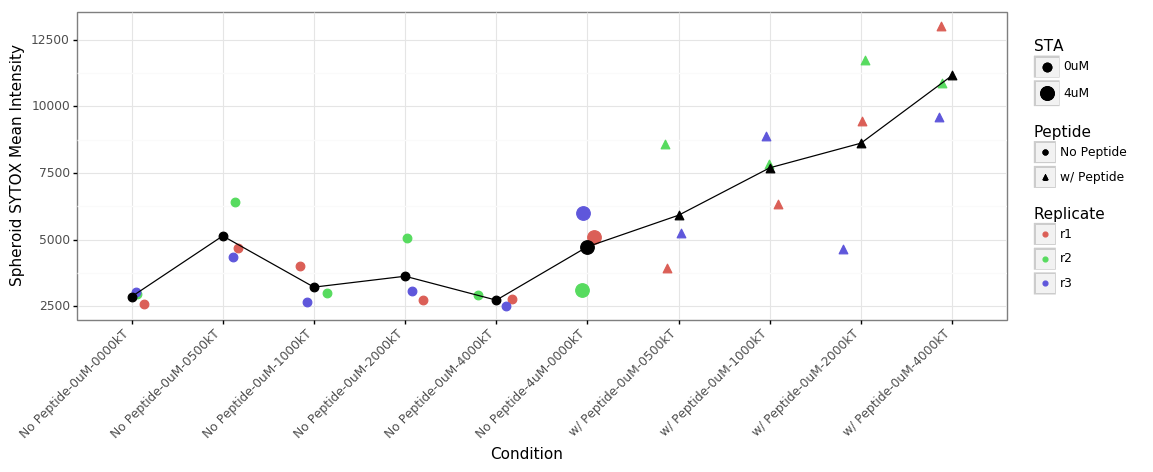

<ggplot: (8763310704760)>

In [33]:
dfshval = dfsh.groupby(['exp_name', 'exp_key', 'exp_has_peptide', 'exp_rep', 'exp_sta_conc'])['ci_SYTOX_mean'].mean().rename('value').reset_index()
plot_series(dfshval, width=.2) + pn.labs(y='Spheroid SYTOX Mean Intensity')

In [34]:
dfsh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1983 entries, 0 to 72
Data columns (total 28 columns):
id                 1983 non-null int64
x                  1983 non-null float64
y                  1983 non-null float64
z                  1983 non-null int64
cm_circularity     1983 non-null float64
cm_diameter        1983 non-null float64
cm_perimeter       1983 non-null float64
cm_size            1983 non-null int64
cm_solidity        1983 non-null float64
nm_circularity     1983 non-null float64
nm_diameter        1983 non-null float64
nm_perimeter       1983 non-null float64
nm_size            1983 non-null int64
nm_solidity        1983 non-null float64
cb_on_border       1983 non-null int64
nb_on_border       1983 non-null int64
ci_SYTOX_mean      1983 non-null float64
ci_HOECHST_mean    1983 non-null float64
ci_BF_mean         1983 non-null float64
exp_cell_count     1983 non-null object
exp_cond           1983 non-null object
exp_grid           1983 non-null object
exp_has_

### Horizontal Staining Bias

In [35]:
dfsh['exp_name'].unique()

array(['0000kT-0uM-np-XY01-1', '0000kT-0uM-np-XY02-2',
       '0000kT-0uM-np-XY03-3', '0000kT-4uM-np-XY01-1',
       '0000kT-4uM-np-XY02-2', '0000kT-4uM-np-XY03-3',
       '0500kT-0uM-np-XY01-1', '0500kT-0uM-np-XY02-2',
       '0500kT-0uM-np-XY03-3', '0500kT-0uM-wp-XY01-1',
       '0500kT-0uM-wp-XY02-2', '0500kT-0uM-wp-XY03-3',
       '1000kT-0uM-np-XY01-1', '1000kT-0uM-np-XY02-2',
       '1000kT-0uM-np-XY03-3', '1000kT-0uM-wp-XY01-1',
       '1000kT-0uM-wp-XY02-2', '1000kT-0uM-wp-XY03-3',
       '2000kT-0uM-np-XY01-1', '2000kT-0uM-np-XY02-2',
       '2000kT-0uM-np-XY03-3', '2000kT-0uM-wp-XY01-1',
       '2000kT-0uM-wp-XY02-2', '2000kT-0uM-wp-XY03-3',
       '4000kT-0uM-np-XY01-1', '4000kT-0uM-np-XY02-2',
       '4000kT-0uM-np-XY03-3', '4000kT-0uM-wp-XY01-1',
       '4000kT-0uM-wp-XY02-2', '4000kT-0uM-wp-XY03-3'], dtype=object)

In [36]:
bad_exps = []

In [37]:
(
    dfsh
    .pipe(lambda df: df[~df['exp_name'].isin(bad_exps)])
    .assign(pos=lambda df: pd.cut(df['x'], bins=10))
    .groupby(['exp_name','exp_has_peptide', 'exp_sta_conc', 'pos'])['ci_SYTOX_mean'].mean().rename('value').reset_index()
    .groupby(['exp_name','exp_has_peptide', 'exp_sta_conc'])
    .apply(lambda g: g.set_index('pos')['value'].rolling(window=3, min_periods=1, center=True).mean())
    .rename('value').reset_index()
).head()

,exp_name,exp_has_peptide,exp_sta_conc,pos,value
0,0000kT-0uM-np-XY01-1,No Peptide,0uM,"(330.629, 669.554]",2336.312604
1,0000kT-0uM-np-XY01-1,No Peptide,0uM,"(669.554, 1005.123]",2375.309017
2,0000kT-0uM-np-XY01-1,No Peptide,0uM,"(1005.123, 1340.692]",2235.498039
3,0000kT-0uM-np-XY01-1,No Peptide,0uM,"(1340.692, 1676.261]",2271.804068
4,0000kT-0uM-np-XY01-1,No Peptide,0uM,"(1676.261, 2011.83]",2437.352150


In [38]:
dfsh['x'].describe()

count    1983.000000
mean     1995.246654
std       833.308479
min       333.984490
25%      1190.928319
50%      1976.287652
75%      2794.012986
max      3689.675631
Name: x, dtype: float64

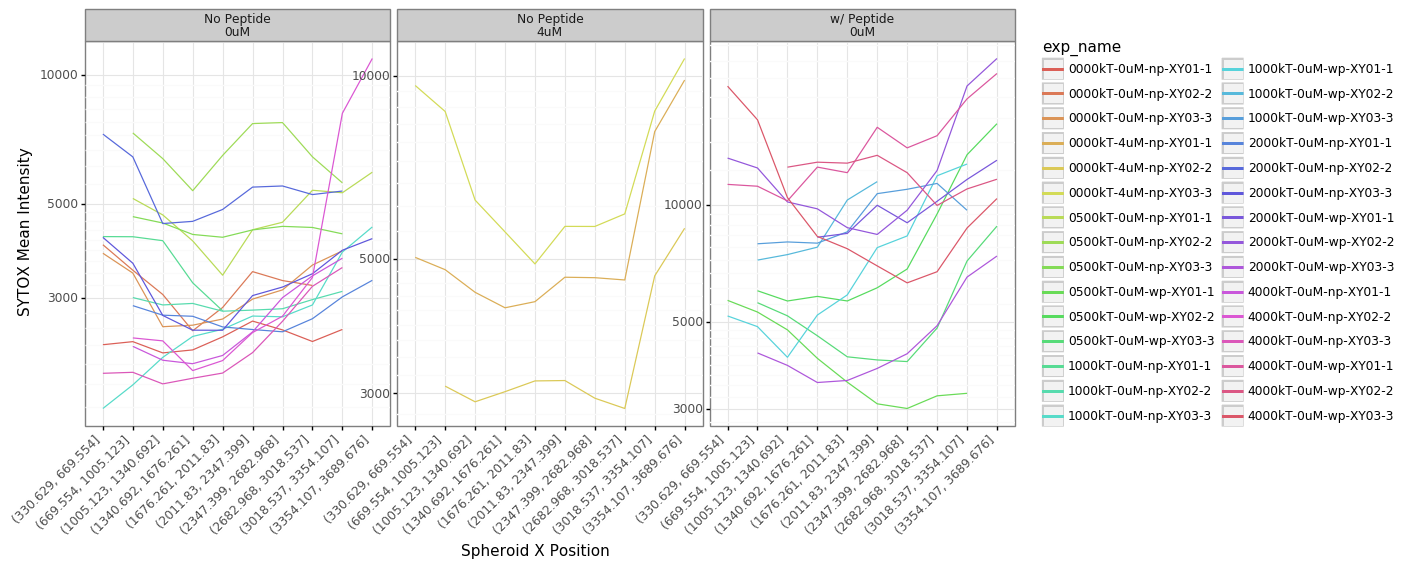

<ggplot: (-9223363273524650713)>

In [39]:
dfp = (
    dfsh
    .pipe(lambda df: df[~df['exp_name'].isin(bad_exps)])
    .assign(pos=lambda df: pd.cut(df['x'], bins=10))
    .groupby(['exp_name','exp_has_peptide', 'exp_sta_conc', 'pos'])['ci_SYTOX_mean'].mean().rename('value').reset_index()
    .groupby(['exp_name','exp_has_peptide', 'exp_sta_conc'])
    .apply(lambda g: g.set_index('pos')['value'].rolling(window=3, min_periods=1, center=True).mean())
    .rename('value').reset_index()
)
(
    pn.ggplot(
        dfp,
        pn.aes(x='pos', y='value', color='exp_name', group='exp_name')
    ) + 
    pn.geom_line() +
    pn.facet_wrap('~ exp_has_peptide + exp_sta_conc', scales='free_y') + 
    pn.scale_y_log10() + 
    pn.labs(x='Spheroid X Position', y='SYTOX Mean Intensity') + 
    pn.theme_bw() + 
    pn.theme(figure_size=(12, 5), axis_text_x=pn.element_text(rotation=45, hjust=1))
)